🖼️ Loaded Image: (1080, 1920, 3)
📱 Initializing MobileNetV3 on mps...
📂 Loading backbone from /Users/dariusgiannoli/Desktop/Recognition-BenchMark/models/mobilenet_v3.pth
✅ Loaded trained head from /Users/dariusgiannoli/Desktop/Recognition-BenchMark/models/mobilenet_v3_head.pkl
✅ MobileNet-V3 Loaded.

🚀 Starting Scan with MobileNet-V3-Small...
   - Window: 224x224 | Stride: 50

🔬 BENCHMARK: MobileNet-V3-Small
Total Windows:   612
Total Time:      4.5137s
Latency/Window:  7.3754ms
Detections:      14
🚀 Speedup Factor vs ResNet: 0.7x FASTER


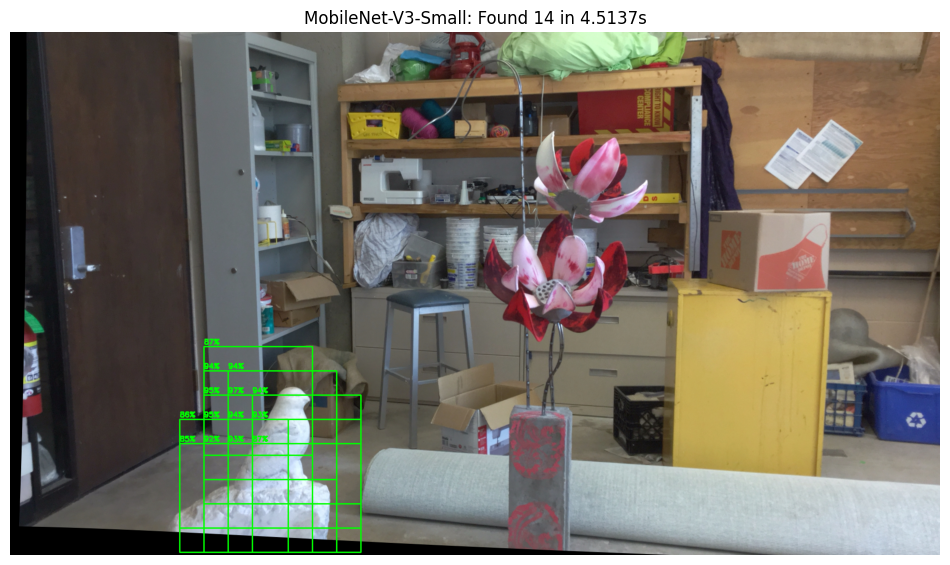

In [1]:
import sys
import os
import cv2
import time
import matplotlib.pyplot as plt
from pathlib import Path

# 1. Setup Path to import 'src'
# This ensures we can find your src folder even if the notebook is nested
current_dir = Path(os.getcwd())
if current_dir.name == "notebooks":
    PROJECT_ROOT = current_dir.parent
elif current_dir.name == "recognition": # In case you are in notebooks/recognition
    PROJECT_ROOT = current_dir.parent.parent
else:
    PROJECT_ROOT = current_dir

sys.path.append(str(PROJECT_ROOT))

# 2. Import MobileNet Wrapper
try:
    from src.detectors.mobilenet import MobileNetDetector
    from src.config import PROJECT_ROOT as CONFIG_ROOT
except ImportError as e:
    print(f"❌ Import Error: {e}")
    print("   -> Make sure you are running this from the 'notebooks' folder.")

# ====================================================
# 3. DEFINE THE SCANNER (Inline for Safety)
# ====================================================
class BruteForceScanner:
    def __init__(self, step_size=50, window_size=(224, 224), conf_threshold=0.85):
        self.step_size = step_size
        self.window_size = window_size
        self.conf_threshold = conf_threshold

    def run(self, image, model, model_name="Unknown"):
        window_w, window_h = self.window_size
        detections = []
        total_windows = 0
        
        print(f"\n🚀 Starting Scan with {model_name}...")
        print(f"   - Window: {window_w}x{window_h} | Stride: {self.step_size}")
        
        t0 = time.perf_counter()

        # Sliding Window Loop
        for y in range(0, image.shape[0] - window_h, self.step_size):
            for x in range(0, image.shape[1] - window_w, self.step_size):
                total_windows += 1
                
                # Crop
                window = image[y:y + window_h, x:x + window_w]
                
                # Predict
                label, conf, _ = model.predict(window)
                
                # Filter
                if label == 'bird' and conf > self.conf_threshold:
                    detections.append((x, y, conf))

        t1 = time.perf_counter()
        total_time = t1 - t0
        
        return {
            "model": model_name,
            "detections": detections,
            "total_windows": total_windows,
            "total_time_sec": total_time,
            "ms_per_window": (total_time / total_windows) * 1000 if total_windows > 0 else 0
        }

    def visualize(self, image, results):
        img_copy = image.copy()
        window_w, window_h = self.window_size
        
        for (x, y, conf) in results['detections']:
            cv2.rectangle(img_copy, (x, y), (x + window_w, y + window_h), (0, 255, 0), 2)
            cv2.putText(img_copy, f"{conf:.0%}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
        img_rgb = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 8))
        plt.imshow(img_rgb)
        plt.title(f"{results['model']}: Found {len(results['detections'])} in {results['total_time_sec']:.4f}s")
        plt.axis('off')
        plt.show()

# ====================================================
# 4. RUN THE BENCHMARK
# ====================================================

# A. Load Image
img_path = CONFIG_ROOT / "data/artroom/im0.png"
if not img_path.exists():
    # Fallback if im0 isn't found
    img_path = CONFIG_ROOT / "data/artroom/bird/yolo/train/images/room_1.png"

img = cv2.imread(str(img_path))
if img is None:
    print(f"❌ Error: Image not found at {img_path}")
else:
    print(f"🖼️ Loaded Image: {img.shape}")

    # B. Load MobileNet
    try:
        model = MobileNetDetector()
        print("✅ MobileNet-V3 Loaded.")
        
        # C. Run Scan
        scanner = BruteForceScanner(step_size=50, window_size=(224, 224), conf_threshold=0.85)
        results = scanner.run(img, model, model_name="MobileNet-V3-Small")
        
        # D. Print Results
        print("\n" + "="*40)
        print(f"🔬 BENCHMARK: {results['model']}")
        print("="*40)
        print(f"Total Windows:   {results['total_windows']}")
        print(f"Total Time:      {results['total_time_sec']:.4f}s")
        print(f"Latency/Window:  {results['ms_per_window']:.4f}ms")
        print(f"Detections:      {len(results['detections'])}")
        print("="*40)
        
        # Compare to your ResNet Baseline (3.11s)
        resnet_time = 3.11 
        if results['total_time_sec'] > 0:
            speedup = resnet_time / results['total_time_sec']
            print(f"🚀 Speedup Factor vs ResNet: {speedup:.1f}x FASTER")

        # E. Visualize
        scanner.visualize(img, results)
        
    except Exception as e:
        print(f"❌ Execution Error: {e}")
        print("NOTE: Ensure you ran 'python training/train_mobilenet.py' first!")